In [1]:
import stan
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import math
import pprint
# work around to get stan working in a notebook
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

In [2]:
# df = pd.read_csv('final_voting_data_long.csv')
df = pd.read_csv('eurovision_merged_covariates_03Feb.csv').drop('Unnamed: 0', axis=1)
df['has_border'] = df['has_border'].replace(np.nan,0)


<Axes: >

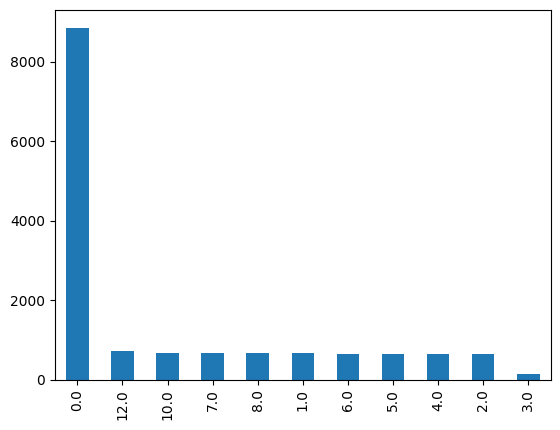

In [3]:
# crop data based on vote to make dataset unbalanced w.r.t vote frequency
# remove most of the data points where vote = 3
# df['Votes'].value_counts().plot(kind='bar')
idx_3 = df.loc[ (df['Votes'] == 3.) & (df['Year'] < 2016)].index
df.drop(idx_3, inplace=True)
df['Votes'].value_counts().plot(kind='bar')

In [4]:
def format_votes(x):
  if x == 12.:
    return 10
  elif x == 10.:
    return 9
  return int(x)
df['indexed_votes'] = df['Votes'].apply(format_votes) + 1
score_options = df['indexed_votes'].unique().tolist()
score_options.sort()
print(score_options)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [5]:
df['male'] = [1 if gender=='male' else 0 for gender in df['Gender']]
df['female'] = [1 if gender=='female' else 0 for gender in df['Gender']]

In [6]:
model = """
data {
  int<lower=2> S;
  int<lower=0> N;
  int<lower=1> D;
  array[N] int<lower=1, upper=S> y;
  array[N] row_vector[D] x;

  //int<lower=0> N_new; // number of predictions
  //array[N_new] row_vector[D] x_new; // covariates for predictions
}
parameters {
  vector[D] beta;
  ordered[S-1] lambda;
}
model {
  vector[N] mu;
  beta ~ normal(0, 10000);
  lambda ~ normal(0, 3.2);
  for (n in 1:N) {
    mu[n] = x[n] * beta;
    y[n] ~ ordered_logistic(mu[n], lambda);
  }
}
generated quantities {
  vector[N] y_hat;
  for (n in 1:N) {
    y_hat[n] = ordered_logistic_rng(x[n] * beta, lambda);
  }

  // out of sample predictions (scores we expet to observe for new data)
  //vector[N_new] y_pred;
  //for (n in 1:N_new)
  //    y_pred[n] = ordered_logistic_rng(x_new[n] * beta, lambda);
}
"""

In [7]:
# test/train split
train_fraction = 0.8
n_train = math.floor(train_fraction * df.shape[0])

In [8]:
# build x matrix
x = df.loc[:,['Own','Other','male','female','has_border','prop_emigrants','comps_since_last_win']].values
x_test = x[n_train:]
x = x[:n_train]
print(x)
print(x.shape)

[[0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  6.53211624e-05 4.30000000e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.42507011e-04 1.20000000e+01]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.69788776e-04 4.30000000e+01]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.21057001e-05 6.00000000e+01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  1.94663692e-04 6.00000000e+01]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  6.90962213e-05 2.50000000e+01]]
(11952, 7)


In [9]:
data = {
    'S': 11,
    'N': n_train,
    'D': x.shape[1],
    'y': df['indexed_votes'][:n_train].values,
    'x': x,
    # 'N_new': df.shape[0]-n_train,
    # 'x_new': x_test
}

In [10]:
posterior = stan.build(model, data=data)
fit = posterior.sample(num_chains=4, num_warmup=1000, num_samples=2500, num_thin=5)

Building...

In file included from /Users/echapman/Library/Caches/httpstan/4.9.1/models/zgt55q2j/model_zgt55q2j.cpp:2:
In file included from /Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/echapm

18 warnings generated.
ld: warning: object file (/Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/stan_services.o) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/lib/libsundials_idas.a(idaa.o)) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/lib/libsundials_cvodes.a(cvodea.o)) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/lib/libsundials_nvecserial.a(s

In [70]:
az_fit = az.from_pystan(
    posterior=fit, 
    observed_data="y", 
    posterior_predictive="y_hat",
    # predictions="y_pred", 
    posterior_model=posterior)

array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n3'}>],
       [<Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n4'}>],
       [<Axes: title={'center': 'beta\n5'}>,
        <Axes: title={'center': 'beta\n5'}>],
       [<Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n6'}>]], dtype=object)

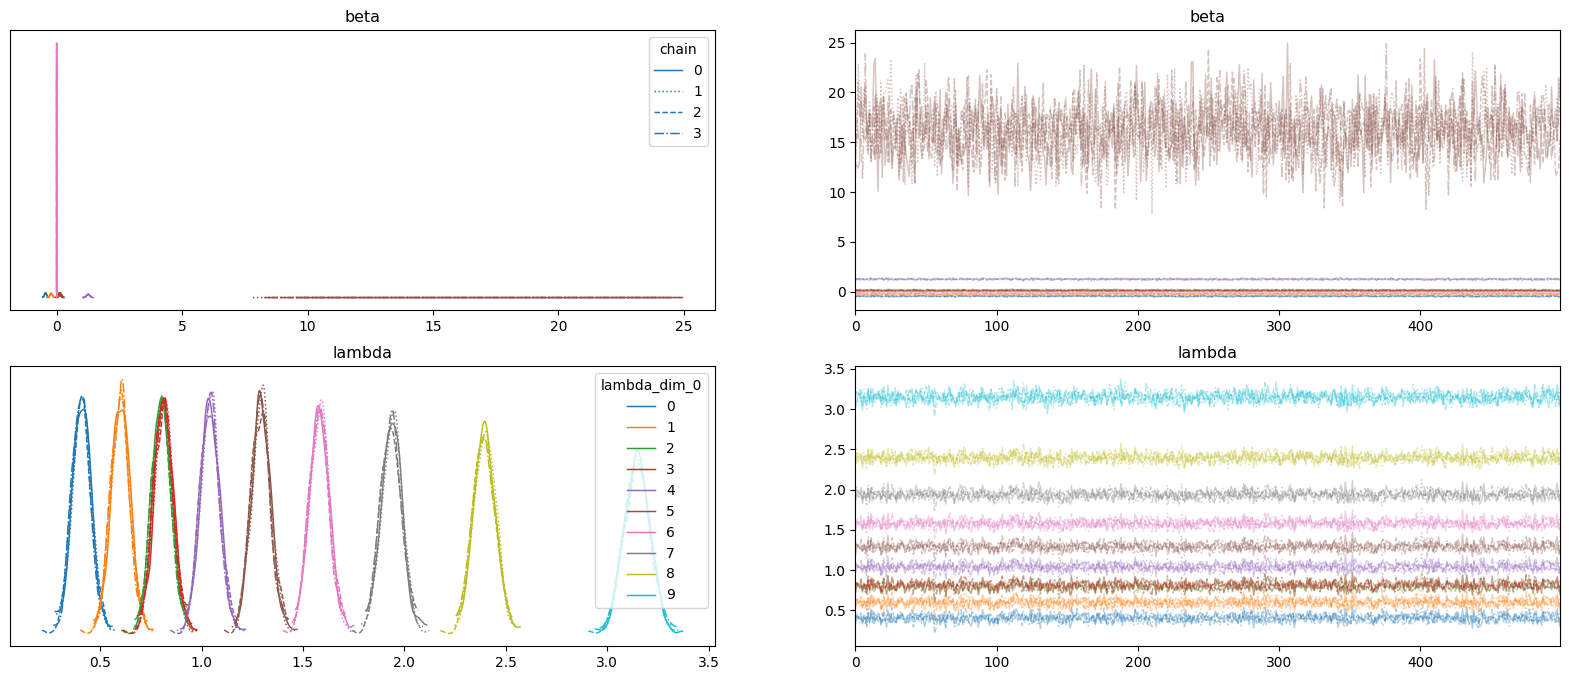

In [71]:
az.plot_trace(az_fit, ["beta","lambda"], figsize=(20,8), legend=True)
az.plot_trace(az_fit, ["beta"], figsize=(25,35), legend=True, compact=False)